# Cross Sections and Reference Frames Code

A note about conventions. In this notebook all code is created from equations which are created using natural units where choose to set $c=1$ and $\hbar = 1 $.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

We first define a four vector class which will allow us to appropriately take the dot product according to the Minkowski space metric with signature (1,-1,-1,-1). This class allows for the creation of four vector objects by inputting the temporal and spatial components of the four-vector you want to create. Then, the operations of addition and scalar product are defined. 

In [10]:
class fourvec: 
    def __init__(A, t, x, y, z):
        A.t = t
        A.x = x
        A.y = y
        A.z = z
        
    def __add__(A, B):
        return fourvec( A.t + B.t, A.x + B.x, A.y + B.y, A.z + B.z)
        
    def dot(A,B):
        return A.t*B.t - A.x*B.x - A.y*B.y - A.z*B.z
    
    def __repr__(self):
        return '{self.__class__.__name__}({A.t},{A.x}, {A.y},{A.z})'.format(self=self)

In order to transform between reference frames, well need to take the Lorentz transformation of some quantities. Here we define a Lorentz transformation function for any four array. This functions boosts CM frame quantities along the z-axis to their lab frame quantities. The function returns arrays which have a shape = (4, len(angles)) where len(angles) is the length of the angles array one is using. All four vectors must be this length so when they're input into the CM function they can be operated on through the standard array operatios. The center of mass frame is defined by the initial kinematics of the scattering process. 

In [11]:
def LT(veclab, vcm, shape):
    """
    Lorentz boost four-array along z-axis into the center of mass frame.
    
    Inputs
    ------
    veclab : array, shape= (4,)
        Array containing elements of a lab frame four-vector.
    vcm : int
        Velocity of center of mass frame. 
    length : int
        Length of array
    Returns
    -------
    cross : array, shape=(4,length,)
        Array of center of mass cross section values.
    
    """
    beta = vcm
    
    veccm = np.empty(shape)
    
    gamma = 1/ np.sqrt(1 - beta**2)
    
    veccm[0] = gamma*(veclab[0] - (beta * veclab[0]))
    
    veccm[1] = veclab[1]
    
    veccm[2] = veclab[2]
    
    veccm[3] = gamma*(veclab[3] - (beta * veclab[0]))
    
    return veccm

We now need to make a function which can determine the CM veclocity based on the initial four vector of the scattering process. 

In [12]:
def comspeed(p1,p2):
    """
    Lorentz boost four-array along z-axis into the center of mass frame.
    
    Inputs
    ------
    p1 : array, shape= (4,)
        Array containing elements of an initial lab frame four-vector.
    p2 : array, shape= (4,)
        Array containing elements of an initial lab frame four-vector. 
   Returns
    -------
    CMspeed : int
        Velocity of the CM frame relative to the lab frame.
    
    """
    CMspeed = np.abs(p1[3] + p2[3])/((p1[0] + p2[0]))
    return CMspeed

We now all the functions needed to create the differential cross section transformation formula. The details of each line are explained in comments. In addition to providing the values of the lab frame differential cross section, the function also produceds a plot of those value in units of nanobarns (nb) $\times$ $Gev^2$. 

In [13]:
def dsiglab(dsigcm, p1, p2, p3, p4, angles):
    """
    Lorentz boost CM differential cross section values to lab frame differential cross section values.
    
    Inputs
    ------
    p1 : array, shape= (4,)
        Array containing elements of particle 1 in the lab frame.
    p2 : array, shape= (4,)
        Array containing elements of particle 2 in the lab frame. 
    p3 : array, shape= (4,)
        Array containing elements of particle 3 in the lab frame. 
    p4 : array, shape= (4,)
        Array containing elements of particle 4 in the lab frame.
    angles: array, shape(N,)
        Array containing values of angles at which the differential cross section is to be evaluated.
   Returns
    -------
    cslab : array, shape(N,)
        Values of lab frame differential cross section in units of nb GeV^2.
    
    """
    #Obtain com speed along z-direction   

    vcm = comspeed(p1,p2) 
    
    beta = vcm 
    
    gamma = 1 / np.sqrt(1 - beta**2)
    
    #Define beta of particle 3 in lab frame
    
    beta3 = np.sqrt(p3[1]**2 + p3[3]**2)/ p3[0]
    
    #Redfine center of mass momenta in terms of lab frame quantities
    #All momentum sent into center of mass cross section must have the same size to be used in general formula
    
    p1cm = LT(p1,vcm, (4,len(angles)))
    p2cm = LT(p2,vcm, (4,len(angles)))
    p3cm = LT(p3,vcm, (4,len(angles)))
    p4cm = LT(p4,vcm, (4,len(angles)))
    
    #Define Lorentz Transformed cosine values from CM to lab frame 
    
    cos = gamma*(np.cos(angles) - (beta / beta3))/(gamma**2*(np.cos(angles) - (beta/beta3))**2 + np.sin(angles)**2)**(1/2)
    
    #Define transformation factor relating CM differential cross section and lab frame differential cross section
    
    dcoscm = gamma*(1 - (beta/beta3)*np.cos(angles)) / (gamma**2 * (np.cos(angles) - (beta / beta3))**2 + np.sin(angles)**2)**(3/2)
    
    #Define conversion factor to yield correct units. This is a dimensionless quantity which scales the cross section
    #values.
    
    nbGeV = (2.56818*10**(-6))
    
    #Differential cross section in the lab frame given by transformed CM differential cross evaluated with
    #CM momenta in terms of lab frame quantities. 
    
    cslab = dcoscm * dsigcm(p1cm, p2cm, p3cm, p4cm, cos)/nbGeV
    
    plt.scatter(angles, cslab, label = 'Code')
    plt.title(' Lab Frame Differential Cross Section',fontsize =15)
    plt.xlabel(r'$ \theta$', fontsize =15)
    plt.ylabel(r'$ \frac{d \sigma}{d \Omega} \quad (nb GeV^2)$',fontsize =15)
    plt.legend()
    plt.show()
    
    return cslab

Now that the code is in place we can run the test of it by comparing it to the data collected in the paper "Weak Neutral Currents in e+ e- Collisions at s**(1/2)=29-GeV". Phys.Rev.Lett. 51 (1983) 1941.https://doi.org/10.1103/PhysRevLett.51.1941. First, we need to define the center of mass cross section as it is defined in the paper.

In [26]:
def muonpp(p1,p2,p3,p4,cos):
    
    alpha = (1/137.036)
    
    g_a = -1/2
    
    sintw = 0.2314
    
    g_v = 2* sintw - (1/2)
    
    G_F = 1.1663787*10**(-5)/((10**9)**2)
    
    M_z = 91190*10^6
    
    p12 = p1 + p2
   
    s = p12**2
        
    coeff = (2 * np.pi*alpha**2)/(4 )
    
    coor1 = 1 + (G_F*g_v*g_v/(np.pi*alpha*np.sqrt(2)))*(s[0]*M_z**2/(s[0] - M_z**2))
    
    signum = (1 + cos**2)*coor1
    
    coor2 = (2*G_F*g_a**2/(np.pi*alpha*np.sqrt(2)))*((s[0]*M_z**2/(s[0] - M_z**2)))*cos
    
    return coeff*(signum + coor2)

For the initial four momentum vectors we can use the following function which will take as input the center of mass energy squared given by $s = (p_1^{\mu} + p_2^{\mu})^2$, and produce the corresponding four vectors in the CM frame.

In [16]:
def initmom(s_sqrt, mass):
    
    E = s_sqrt/2
    
    pz = np.sqrt(E**2 - (mass)**2)
    
    p1 = np.array([E, 0, 0, pz])
    
    p2 = np.array([E, 0, 0, - pz])
    
    return p1,p2

Now we need to create the four momentum vectors which are evaluated at certain angles. I've defined two other functions to create the final four vectors for this particular test.

In [30]:
# Define initial momenta for testing muonpp production

me = 0.511*10**6 # Define electron mass in eV

alpha = 1/ 137.036 

s_sqrt = 29*10**9 # Define sqrt(s) value in units of eV

p1muon,p2muon = initmom(s_sqrt,me) #Initial four vectors defined

#Define outgoing momenta in the lab frame
def p3(angle,E3,pmom3):
    
    p3 = np.array([np.full(len(angle),E3), pmom3*np.sin(angle), np.zeros(len(angle)), pmom3*np.cos(angle)])
    
    return p3

def p4(angle,E4,pmom4):
    
    p4 = np.array([np.full(len(angle),E4), - pmom4*np.sin(angle), np.zeros(len(angle)), -pmom4*np.cos(angle)])
    
    return p4

#Define an array of angles and cosine values
angle = np.linspace(0,np.pi,100)
cosang = np.cos(angle)

#Define energy of outgoing muons in CM frame 
p3mom = np.sqrt(p1muon[0]**2 - (105.658*10**6)**2)
p4mom = p3mom

#Define outgoing momenta 
p3muon = p3(angle,p1muon[0],p3mom)

p4muon = p4(angle,p1muon[0],p4mom)

The result. I've multiplied the cross section result by $\sqrt{s}$ to make the units correct relative to what was plotted in the paper. 

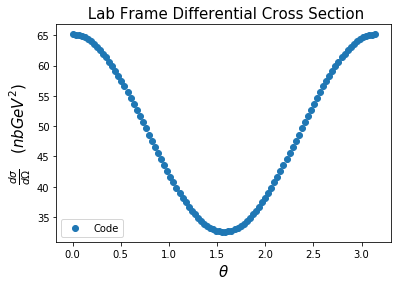

In [27]:
muonpplab = dsiglab(muonpp,p1muon,p2muon,p3muon,p4muon,angle)

Here we compare the results with the data from the experiment and the theoretical value. 

In [28]:
muonppcosang = np.array([-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65])
muonppdsigdcos = np.array([56.332,49.477,42.122,41.997,33.449,33.368,31.194,35.599,37.012,35.298,37.183,35.897,45.44,44.022])
muonppdsigdcoserr = np.array([2.572,2.242,2.066,2.014,1.779,1.782,1.714,1.797,1.857,1.793,1.864,1.813,2.049,2.108])

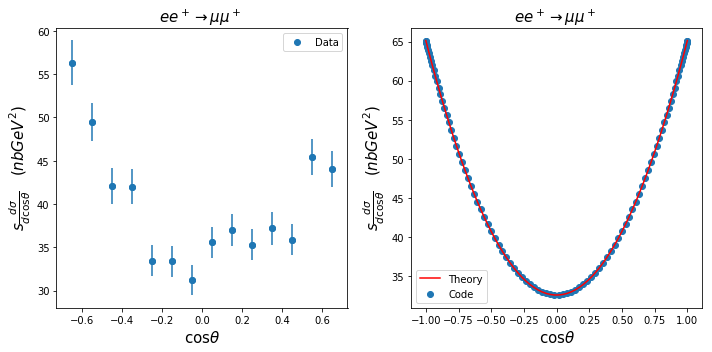

In [31]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.scatter(muonppcosang, muonppdsigdcos, label = 'Data')
plt.errorbar(muonppcosang, muonppdsigdcos, yerr = muonppdsigdcoserr, fmt = 'o')
plt.title(r'$e e^+ \rightarrow \mu \mu^+$ ', fontsize = 15)
plt.xlabel(r'$\cos \theta$', fontsize =15)
plt.ylabel(r'$s \frac{d\sigma}{d \cos \theta} \quad (nb GeV^2)$', fontsize = 15)
plt.legend()

plt.subplot(1,2,2)
plt.scatter(cosang, muonpplab, label = 'Code')
plt.plot(cosang,(2 * np.pi* alpha**2/(4*s_sqrt**2))*(1 + np.cos(angle)**2)*s_sqrt**2/(2.56818*10**(-6)), label= 'Theory',  color = 'red')
plt.title(r'$e e^+ \rightarrow \mu \mu^+$ ',fontsize =15)
plt.xlabel(r'$\cos \theta$', fontsize =15)
plt.ylabel(r'$s \frac{d \sigma}{d \cos \theta} \quad (nb GeV^2)$',fontsize =15)
plt.legend()

plt.tight_layout()

plt.show()

In [ ]:
###Create Initial Four Momenta Here###

p1 = np.array([])
p2 = np.array([])
p3 = np.array([])
p4 = np.array([])

In [33]:
###Create Center of Mass Cross Section Formula Here###

def cscm(p1,p2,p3,p4,cos):
    """
    Cross section formula calculated in the center of mass frame.
    
    Inputs
    ------
    pi : array, shape= (4,)
        Array specifying center of mass four momentum vector written in terms of lab frame quantities  of particle i.
    cos: array, shape=(N,)
        Array of cosine values.
        
    Returns
    -------
    cross : array, shape=(len(cos),)
        Array of center of mass cross section values.
    
    """
    
    return cross